# Model recovery attack: `wine`

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import mra
from mra import *

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

xy = np.loadtxt("../datasets/wine.csv", delimiter=";")
np.random.shuffle(xy)
x = xy[:,0:-1]
y = xy[:,-1]

min_values = np.array([min(x[:,i]) for i in range(x.shape[1])])
max_values = np.array([max(x[:,i]) for i in range(x.shape[1])])
x = (x-min_values)/(max_values - min_values)
y = y.reshape((len(x), 1)).astype("float32")
train_ds = make_dataset(x, y, lambda t: t)

mra = mra(train_ds)

In [3]:
def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.BatchNormalization()(xin)
    x = tf.keras.layers.Dense(64, activation="relu")(xin)
    output = tf.keras.layers.Dense(64, activation="relu")(x)
    return tf.keras.Model(xin, output)

def make_g(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(64, activation="relu")(xin)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(11, activation="softmax")(x)
    return tf.keras.Model(xin, output)

In [4]:
log_train = mra.train(
    make_f,
    make_g,
    loss_fn=tf.keras.losses.sparse_categorical_crossentropy,
    batch_size=32,
    epoch=5,
    lr=0.001,
    verbose=True, log_every=50
    )

Iteration 0001: Training loss: 2.3770
Iteration 0051: Training loss: 1.2409
Iteration 0101: Training loss: 1.4933
Iteration 0151: Training loss: 1.0491
Iteration 0201: Training loss: 0.8987


In [5]:
def make_generator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(512, activation=act)(xin)
    x = tf.keras.layers.Dense(256, activation=act)(x)
    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = tf.keras.layers.Dense(11, activation="sigmoid")(x)
    return tf.keras.Model(xin, x)

In [6]:
log_attack = mra.attack(
    attack_iter=100,
    make_generator=make_generator,
    input_noise="normal",
    input_z=True,
    model_leak=True,
    lr_x=0.001,
    lr_f=0.0001,
    epoch=200,
    iter_x=50,
    iter_f=1,
    verbose=True, log_every=1)

Iteration 0001: RG-uniform: 0.1606, RG-normal: 0.1631, reconstruction validation: 0.0003
Iteration 0002: RG-uniform: 0.1744, RG-normal: 0.1515, reconstruction validation: 0.0005
Iteration 0003: RG-uniform: 0.1521, RG-normal: 0.1617, reconstruction validation: 0.0007
Iteration 0004: RG-uniform: 0.1705, RG-normal: 0.1553, reconstruction validation: 0.0004
Iteration 0005: RG-uniform: 0.1733, RG-normal: 0.1386, reconstruction validation: 0.0007
Iteration 0006: RG-uniform: 0.1828, RG-normal: 0.1511, reconstruction validation: 0.0007
Iteration 0007: RG-uniform: 0.1795, RG-normal: 0.1505, reconstruction validation: 0.0020
Iteration 0008: RG-uniform: 0.1803, RG-normal: 0.1457, reconstruction validation: 0.0016
Iteration 0009: RG-uniform: 0.1855, RG-normal: 0.1413, reconstruction validation: 0.0021
Iteration 0010: RG-uniform: 0.1529, RG-normal: 0.1408, reconstruction validation: 0.0029
Iteration 0011: RG-uniform: 0.1705, RG-normal: 0.1531, reconstruction validation: 0.0027
Iteration 0012: RG-un

In [7]:
np.savetxt("./log/wine.csv", log_attack, delimiter=",")

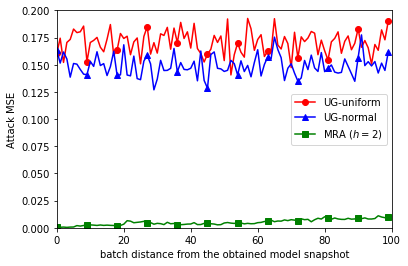

In [8]:
plt.xlim([0,100])
plt.ylim([0,0.2])
plt.ylabel('Attack MSE')
plt.xlabel('batch distance from the obtained model snapshot')
ran = [i for i in range(100)]
plt.plot(ran, log_attack[:,0], 'ro-', ran, log_attack[:,1], 'b^-', ran, log_attack[:,2], 'gs-', markevery=np.arange(0, 101, 9))
plt.legend(['UG-uniform', 'UG-normal', 'MRA ($h=2$)'], loc='center right')
plt.savefig("fig/wine.pdf", bbox_inches='tight')